Given a new purchase order, what is the predicted actual lead time?

In [31]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import display

DATA_PATH = Path().cwd().parent / "data"

def read_data(file_name):
    return pl.read_csv(DATA_PATH / file_name, try_parse_dates=True)

ship_df = read_data("shipments.csv")
purchase_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")

In [32]:
ship_df


shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status
str,str,i64,str,str,str,str,date,date,str
"""SH-00000001""","""PO-0104861""",6,"""Road""","""CIF""","""Mexico""","""ST-00452""",2025-02-03,2025-02-10,"""Delivered"""
"""SH-00000002""","""PO-0099598""",3,"""Sea""","""EXW""","""India""","""ST-00086""",2024-08-21,2024-09-27,"""Delayed"""
"""SH-00000003""","""PO-0110843""",8,"""Road""","""FOB""","""Italy""","""ST-00252""",2023-01-21,2023-01-30,"""In Transit"""
"""SH-00000004""","""PO-0047627""",6,"""Sea""","""FOB""","""Argentina""","""ST-00800""",2023-07-03,2023-08-05,"""In Transit"""
"""SH-00000005""","""PO-0003236""",6,"""Road""","""DAP""","""Brazil""","""ST-01995""",2025-06-19,2025-06-27,"""Delivered"""
…,…,…,…,…,…,…,…,…,…
"""SH-00217496""","""PO-0033886""",2,"""Road""","""EXW""","""Argentina""","""ST-01757""",2023-09-30,2023-10-07,"""In Transit"""
"""SH-00217497""","""PO-0038120""",7,"""Road""","""EXW""","""Mexico""","""ST-01876""",2024-08-14,2024-08-27,"""Delivered"""
"""SH-00217498""","""PO-0079713""",3,"""Air""","""DAP""","""Spain""","""ST-01330""",2023-12-25,2024-01-02,"""In Transit"""


Text(0.5, 1.0, 'Transit Event Status Distribution (Top 10)')

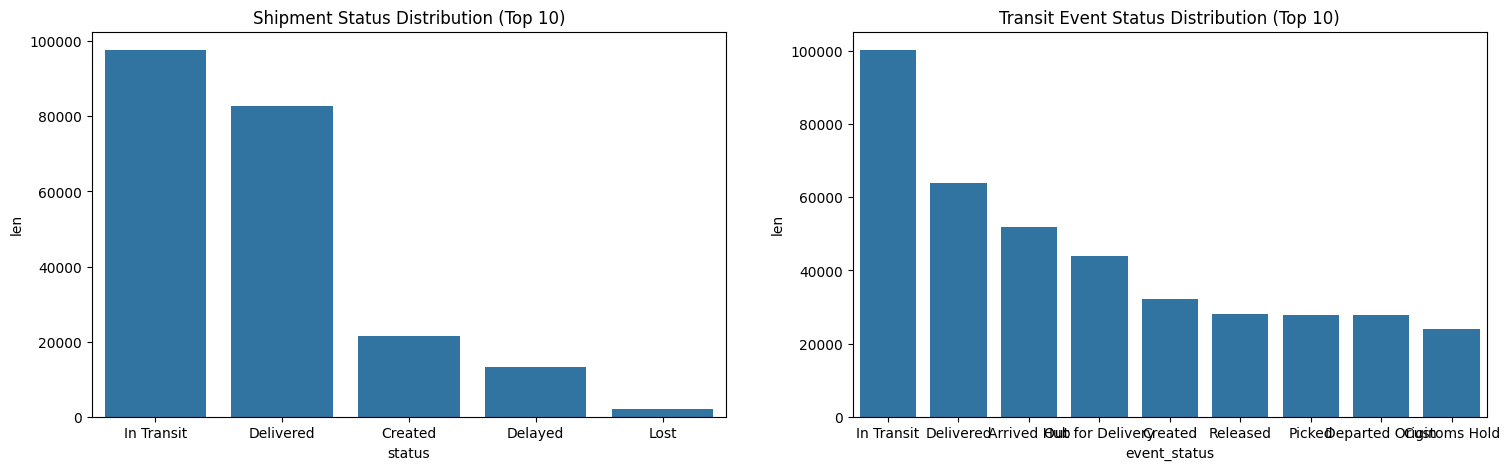

In [33]:
# Basic distributions to understand shipment and event statuses
status_summary = ship_df.group_by("status").len().sort("len", descending=True)
event_status_summary = transit_events_df.group_by("event_status").len().sort("len", descending=True)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=status_summary.head(10).to_pandas(), x="status", y
="len")
plt.title("Shipment Status Distribution (Top 10)")
plt.subplot(1, 2, 2)
sns.barplot(data=event_status_summary.head(10).to_pandas(), x="event_status", y="len")
plt.title("Transit Event Status Distribution (Top 10)")


In [37]:
# Summaries of delivered shipments and latest in-flight events
actual_delivery = (
    transit_events_df
    .filter(
        (pl.col("event_status") == "Delivered")
        & pl.col("event_ts").is_not_null()
        & (pl.col("location_type") == "Destination")
    )
    .group_by("shipment_id")
    .agg(pl.col("event_ts").max().alias("actual_delivery_ts"))
)
# lets assume that the latest event for each shipment is the current status
latest_event = (
    transit_events_df
    .group_by("shipment_id")
    .agg([
        pl.col("event_ts").max().alias("last_event_ts"),
        pl.col("event_status").sort_by("event_ts").last().alias("last_event_status"),
    ])
)
# from len transit events only n is actually usefull
print(f'from {transit_events_df.height} transit events, only {actual_delivery.height} are useful for actual delivery times.')

from 400000 transit events, only 6967 are useful for actual delivery times.


In [38]:
# Step 2: combine shipment facts with purchase-order context
shipments_enriched = (
    ship_df
    .join(latest_event, on="shipment_id", how="left")
    .join(actual_delivery, on="shipment_id", how="left")
    .join(
        purchase_df.select("po_id", "order_date", "promised_date", "supplier_id", "order_qty", "status"),
        on="po_id",
        how="left",
    )
)
# last_event_status actual_delivery_ts last_event_ts are often null for in-flight shipments
# because not all shipments have events yet

shipments_enriched

shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,last_event_ts,last_event_status,actual_delivery_ts,order_date,promised_date,supplier_id,order_qty,status_right
str,str,i64,str,str,str,str,date,date,str,datetime[μs],str,datetime[μs],date,date,str,i64,str
"""SH-00000001""","""PO-0104861""",6,"""Road""","""CIF""","""Mexico""","""ST-00452""",2025-02-03,2025-02-10,"""Delivered""",null,null,null,2024-05-25,2024-06-24,"""S-0025""",7,"""Closed"""
"""SH-00000002""","""PO-0099598""",3,"""Sea""","""EXW""","""India""","""ST-00086""",2024-08-21,2024-09-27,"""Delayed""",2024-03-09 04:00:00,"""Out for Delivery""",null,2024-12-11,2024-12-29,"""S-0002""",11,"""Closed"""
"""SH-00000003""","""PO-0110843""",8,"""Road""","""FOB""","""Italy""","""ST-00252""",2023-01-21,2023-01-30,"""In Transit""",2023-02-27 07:00:00,"""In Transit""",null,2024-04-28,2024-05-14,"""S-0178""",12,"""Closed"""
"""SH-00000004""","""PO-0047627""",6,"""Sea""","""FOB""","""Argentina""","""ST-00800""",2023-07-03,2023-08-05,"""In Transit""",2025-09-02 20:00:00,"""Delivered""",null,2024-10-27,2024-12-01,"""S-0091""",13,"""Closed"""
"""SH-00000005""","""PO-0003236""",6,"""Road""","""DAP""","""Brazil""","""ST-01995""",2025-06-19,2025-06-27,"""Delivered""",null,null,null,2023-04-01,2023-04-27,"""S-0036""",11,"""Closed"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SH-00217496""","""PO-0033886""",2,"""Road""","""EXW""","""Argentina""","""ST-01757""",2023-09-30,2023-10-07,"""In Transit""",null,null,null,2024-02-25,2024-03-23,"""S-0200""",11,"""Closed"""
"""SH-00217497""","""PO-0038120""",7,"""Road""","""EXW""","""Mexico""","""ST-01876""",2024-08-14,2024-08-27,"""Delivered""",2023-07-30 22:00:00,"""Arrived Hub""",null,2023-02-12,2023-03-08,"""S-0112""",8,"""Closed"""
"""SH-00217498""","""PO-0079713""",3,"""Air""","""DAP""","""Spain""","""ST-01330""",2023-12-25,2024-01-02,"""In Transit""",2023-09-12 05:00:00,"""Arrived Hub""",null,2025-05-17,2025-06-29,"""S-0067""",7,"""Closed"""


In [39]:
# how much from shippements.status = Delivered are the transit_events.event_status = Delivered & locatio_type = 'Destination'
delivered_shipments = shipments_enriched.filter(pl.col("status") == "Delivered")
delivered_with_events = delivered_shipments.filter(pl.col("actual_delivery_ts").is_not_null())

print(f'Out of {delivered_shipments.height} shipments with status Delivered, only {delivered_with_events.height} have actual delivery events recorded at Destination location.')

Out of 82824 shipments with status Delivered, only 2664 have actual delivery events recorded at Destination location.


Number of shipments with order_date > ship_date:  108981 normal shipments:  108519


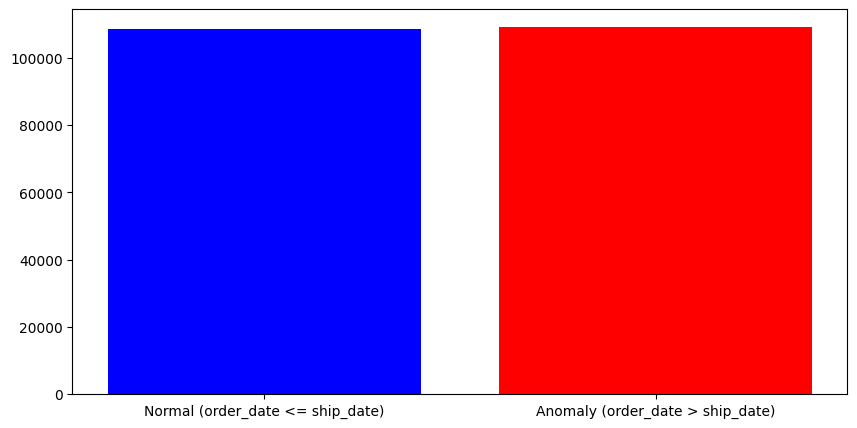

In [ ]:
# show order_date > ship_date annomalies

plt.figure(figsize=(10, 5))
# normal count wrong count
plt.bar(
    ["Normal (order_date <= ship_date)", "Anomaly (order_date > ship_date)"],
    [
        shipments_enriched.filter(pl.col("order_date") <= pl.col("ship_date")).height,
        shipments_enriched.filter(pl.col("order_date") > pl.col("ship_date")).height,
    ],
    color=["blue", "red"]
)
print(
    "Number of shipments with order_date > ship_date: ",
    shipments_enriched.filter(pl.col("order_date") > pl.col("ship_date")).height,
    "normal shipments: ",
    shipments_enriched.filter(pl.col("order_date") <= pl.col("ship_date")).height
)

In [ ]:
# lets assume half of data is wrong and work only with the rest
clean_shipments = shipments_enriched.filter(pl.col("order_date") <= pl.col("ship_date"))
print(" Valid shipments count: ", clean_shipments.height)
clean_shipments = clean_shipments.filter(pl.col("actual_delivery_ts").is_not_null())
print("Shipments with actual delivery timestamp count: ", clean_shipments.height)
# also let us only get shipments that were fully shipped (`po.order_qty` == sum of `ship.ship_qty`)
clean_shipments = clean_shipments.join(
    ship_df.group_by("po_id").agg(pl.col("ship_qty").sum().alias("total_shipped_qty")),
    on="po_id",
    how="inner"
).filter(pl.col("order_qty") == pl.col("total_shipped_qty"))
print("Fully shipped clean shipments count: ", clean_shipments.height)

 Valid shipments count:  108519
Shipments with actual delivery timestamp count:  27751
Fully shipped clean shipments count:  1516


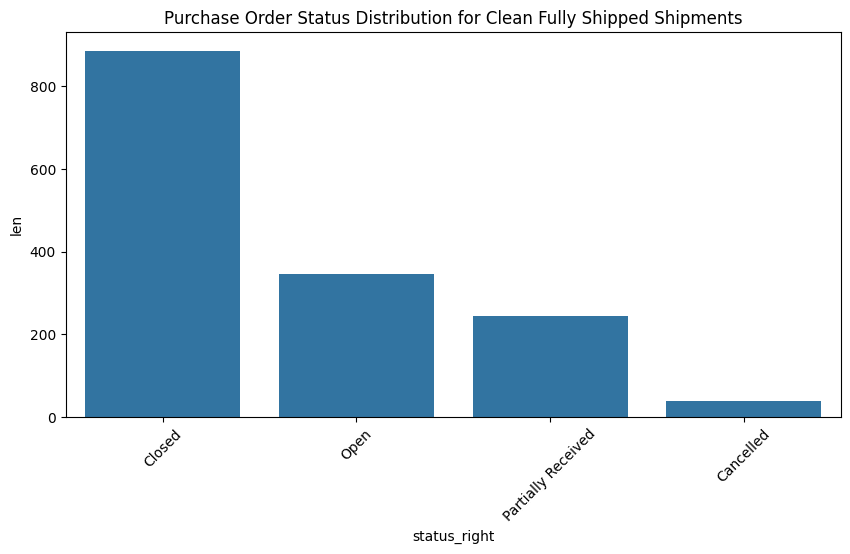

In [ ]:
# let's check how does it align with po.status (should be `Closed`)
# plot pucharse_order.status
data = clean_shipments.group_by("status_right").len().sort("len", descending=True).to_pandas()
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x="status_right", y="len")
plt.title("Purchase Order Status Distribution for Clean Fully Shipped Shipments")
plt.xticks(rotation=45)
plt.show()
# HOW? I just don't get it. Are those statuses not updated? Because they were FULLY RECEIVED...

# To SUM UP.

- **Cell 5:** Only 6,967 of the 400,000 transit events correspond to "Delivered" scans at the destination, so barely ~1.7% of the raw telemetry is usable for ground-truth delivery timestamps.
- **Cell 7:** Even among the 82,824 shipments flagged as Delivered, just 2,664 (≈3.2%) actually have those destination delivery events, which means the shipment.status flag cannot be trusted as proof of receipt.
- **Cell 8:** Order timestamps are corrupt for roughly half of the records (108,981 cases where `order_date > ship_date` versus 108,519 valid rows), so the timeline fields coming from purchase orders are unreliable without heavy filtering.
- **Cell 9:** After removing the obvious timestamp errors and requiring a recorded delivery plus full PO fulfillment, the cohort shrinks from 108,519 "valid" shipments to only 205—data that small can’t support robust modeling and is likely biased toward the cleanest cases.
- **Cell 10:** Those fully received shipments still span multiple PO statuses instead of being uniformly `Closed`, so upstream PO lifecycle tracking is out of sync with the shipment reality.

Text(0.5, 1.0, 'Mean Transit Time by Supplier Distribution')

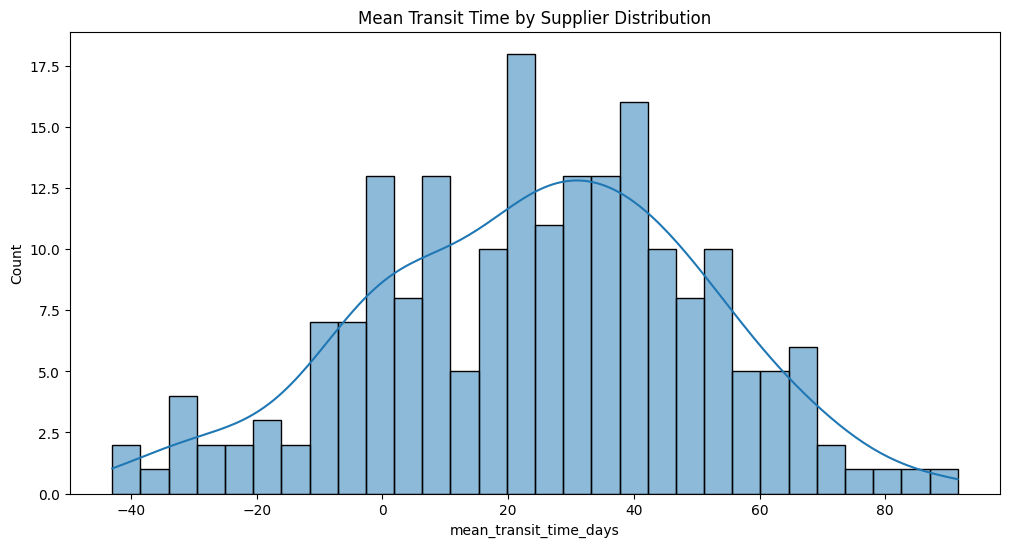

In [ ]:
# mean transit time by supplier
mean_transit_time_by_supplier = (
    shipments_enriched
    .with_columns([
        (pl.col("actual_delivery_ts") - pl.col("ship_date")).dt.total_days().cast(pl.Int32).alias("transit_time_days")
    ])
    .group_by("supplier_id")
    .agg(pl.col("transit_time_days").mean().alias("mean_transit_time_days"))
)
plt.figure(figsize=(12, 6))
sns.histplot(mean_transit_time_by_supplier.to_pandas(), x="mean_transit_time_days", bins=30, kde=True)
plt.title("Mean Transit Time by Supplier Distribution")


Text(0.5, 1.0, 'On-Time Delivery Rate by Supplier Distribution')

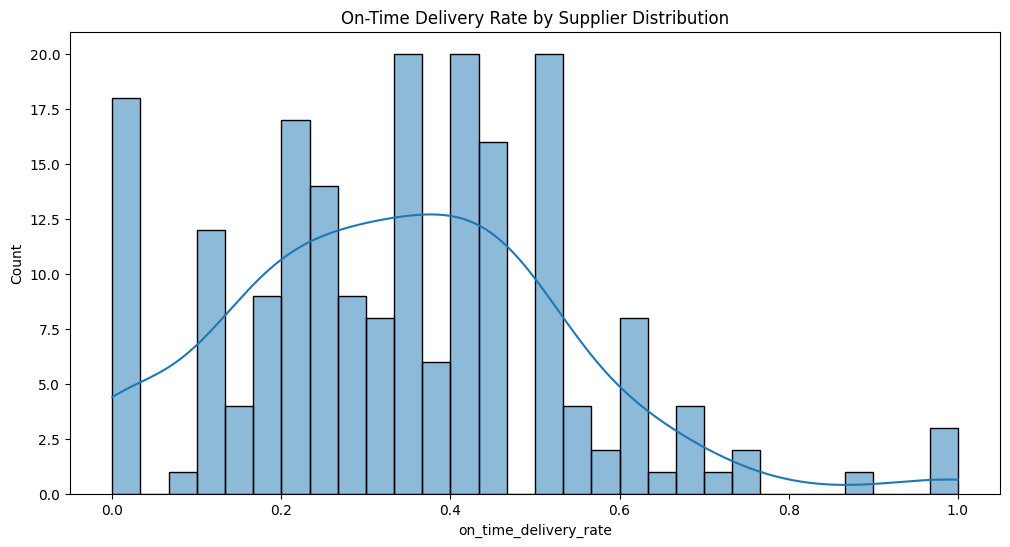

In [ ]:
# on time delivery rate by supplier
on_time_delivery_by_supplier = (
    clean_shipments
    .with_columns([
        (pl.col("actual_delivery_ts") <= pl.col("promised_date")).alias("on_time_delivery")
    ])
    .group_by("supplier_id")
    .agg(pl.col("on_time_delivery").mean().alias("on_time_delivery_rate"))
)
plt.figure(figsize=(12, 6))
sns.histplot(on_time_delivery_by_supplier.to_pandas(), x="on_time_delivery_rate", bins=30, kde=True)
plt.title("On-Time Delivery Rate by Supplier Distribution")

In [40]:
shipments_enriched = shipments_enriched.with_columns([
    (pl.col("eta_date") - pl.col("ship_date")).dt.total_days().cast(pl.Int32).alias("planned_transit_days"),
    (pl.col("promised_date") - pl.col("order_date")).dt.total_days().cast(pl.Int32).alias("promised_lead_time_days"),
    (pl.col("actual_delivery_ts") - pl.col("ship_date")).dt.total_days().cast(pl.Int32).alias("actual_transit_days"),
    (pl.col("actual_delivery_ts") - pl.col("order_date")).dt.total_days().cast(pl.Int32).alias("actual_lead_time_days"),
    (pl.col("actual_delivery_ts") - pl.col("eta_date")).dt.total_days().cast(pl.Int32).alias("delay_vs_eta_days"),
    (pl.col("actual_delivery_ts") - pl.col("promised_date")).dt.total_days().cast(pl.Int32).alias("delay_vs_promised_days"),
    pl.when(pl.col("actual_delivery_ts").is_not_null())
    .then(pl.col("actual_delivery_ts"))
    .otherwise(pl.col("last_event_ts"))
    .alias("best_available_ts"),
])
shipments_enriched

shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,last_event_ts,last_event_status,actual_delivery_ts,order_date,promised_date,supplier_id,order_qty,status_right,planned_transit_days,promised_lead_time_days,actual_transit_days,actual_lead_time_days,delay_vs_eta_days,delay_vs_promised_days,best_available_ts
str,str,i64,str,str,str,str,date,date,str,datetime[μs],str,datetime[μs],date,date,str,i64,str,i32,i32,i32,i32,i32,i32,datetime[μs]
"""SH-00000001""","""PO-0104861""",6,"""Road""","""CIF""","""Mexico""","""ST-00452""",2025-02-03,2025-02-10,"""Delivered""",null,null,null,2024-05-25,2024-06-24,"""S-0025""",7,"""Closed""",7,30,null,null,null,null,null
"""SH-00000002""","""PO-0099598""",3,"""Sea""","""EXW""","""India""","""ST-00086""",2024-08-21,2024-09-27,"""Delayed""",2024-03-09 04:00:00,"""Out for Delivery""",null,2024-12-11,2024-12-29,"""S-0002""",11,"""Closed""",37,18,null,null,null,null,2024-03-09 04:00:00
"""SH-00000003""","""PO-0110843""",8,"""Road""","""FOB""","""Italy""","""ST-00252""",2023-01-21,2023-01-30,"""In Transit""",2023-02-27 07:00:00,"""In Transit""",null,2024-04-28,2024-05-14,"""S-0178""",12,"""Closed""",9,16,null,null,null,null,2023-02-27 07:00:00
"""SH-00000004""","""PO-0047627""",6,"""Sea""","""FOB""","""Argentina""","""ST-00800""",2023-07-03,2023-08-05,"""In Transit""",2025-09-02 20:00:00,"""Delivered""",null,2024-10-27,2024-12-01,"""S-0091""",13,"""Closed""",33,35,null,null,null,null,2025-09-02 20:00:00
"""SH-00000005""","""PO-0003236""",6,"""Road""","""DAP""","""Brazil""","""ST-01995""",2025-06-19,2025-06-27,"""Delivered""",null,null,null,2023-04-01,2023-04-27,"""S-0036""",11,"""Closed""",8,26,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SH-00217496""","""PO-0033886""",2,"""Road""","""EXW""","""Argentina""","""ST-01757""",2023-09-30,2023-10-07,"""In Transit""",null,null,null,2024-02-25,2024-03-23,"""S-0200""",11,"""Closed""",7,27,null,null,null,null,null
"""SH-00217497""","""PO-0038120""",7,"""Road""","""EXW""","""Mexico""","""ST-01876""",2024-08-14,2024-08-27,"""Delivered""",2023-07-30 22:00:00,"""Arrived Hub""",null,2023-02-12,2023-03-08,"""S-0112""",8,"""Closed""",13,24,null,null,null,null,2023-07-30 22:00:00
"""SH-00217498""","""PO-0079713""",3,"""Air""","""DAP""","""Spain""","""ST-01330""",2023-12-25,2024-01-02,"""In Transit""",2023-09-12 05:00:00,"""Arrived Hub""",null,2025-05-17,2025-06-29,"""S-0067""",7,"""Closed""",8,43,null,null,null,null,2023-09-12 05:00:00


In [ ]:
# Step 4: extend with latest-known delay signals for shipments still in transit
shipments_enriched = shipments_enriched.with_columns([
    (pl.col("best_available_ts") - pl.col("eta_date")).dt.total_days().cast(pl.Int32).alias("latest_known_delay_vs_eta_days"),
    (pl.col("best_available_ts") - pl.col("promised_date")).dt.total_days().cast(pl.Int32).alias("latest_known_delay_vs_promised_days"),
])

shipments_enriched = shipments_enriched.with_columns([
    pl.when(pl.col("actual_delivery_ts").is_null() & pl.col("best_available_ts").is_not_null())
    .then(pl.col("latest_known_delay_vs_eta_days"))
    .otherwise(pl.col("delay_vs_eta_days"))
    .alias("best_delay_vs_eta_days"),
    pl.when(pl.col("actual_delivery_ts").is_null() & pl.col("best_available_ts").is_not_null())
    .then(pl.col("latest_known_delay_vs_promised_days"))
    .otherwise(pl.col("delay_vs_promised_days"))
    .alias("best_delay_vs_promised_days"),
])


In [ ]:
# Step 5: classify shipments and craft a short narrative
shipments_enriched = shipments_enriched.with_columns([
    pl.when(pl.col("best_delay_vs_eta_days").is_null())
    .then(pl.lit(None))
    .otherwise(pl.col("best_delay_vs_eta_days") > 0)
    .alias("is_delayed_computed"),
    pl.when(pl.col("actual_delivery_ts").is_null())
    .then(
        pl.when(pl.col("best_available_ts").is_null())
        .then(pl.lit("No transit events ingested"))
        .otherwise(
            pl.concat_str([
                pl.lit("Latest status: "),
                pl.col("last_event_status").fill_null("Unknown"),
                pl.lit(" ("),
                pl.when(pl.col("best_delay_vs_eta_days").is_null())
                .then(pl.lit("?"))
                .otherwise(pl.col("best_delay_vs_eta_days").cast(pl.Int32).cast(pl.Utf8)),
                pl.lit(" days vs ETA)"),
            ])
        )
    )
    .otherwise(
        pl.when(pl.col("delay_vs_eta_days") > 0)
        .then(pl.concat_str([
            pl.lit("Arrived "),
            pl.col("delay_vs_eta_days").cast(pl.Int32).cast(pl.Utf8),
            pl.lit(" days after ETA"),
        ]))
        .when(pl.col("delay_vs_eta_days") < 0)
        .then(pl.concat_str([
            pl.lit("Arrived "),
            (-pl.col("delay_vs_eta_days")).cast(pl.Int32).cast(pl.Utf8),
            pl.lit(" days before ETA"),
        ]))
        .otherwise(pl.lit("Arrived on ETA"))
    )
    .alias("delay_narrative"),
])

shipments_enriched


shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,last_event_ts,last_event_status,actual_delivery_ts,order_date,promised_date,supplier_id,order_qty,status_right,planned_transit_days,promised_lead_time_days,actual_transit_days,actual_lead_time_days,delay_vs_eta_days,delay_vs_promised_days,best_available_ts,latest_known_delay_vs_eta_days,latest_known_delay_vs_promised_days,best_delay_vs_eta_days,best_delay_vs_promised_days,is_delayed_computed,delay_narrative
str,str,i64,str,str,str,str,date,date,str,datetime[μs],str,datetime[μs],date,date,str,i64,str,i32,i32,i32,i32,i32,i32,datetime[μs],i32,i32,i32,i32,bool,str
"""SH-00000001""","""PO-0104861""",6,"""Road""","""CIF""","""Mexico""","""ST-00452""",2025-02-03,2025-02-10,"""Delivered""",null,null,null,2024-05-25,2024-06-24,"""S-0025""",7,"""Closed""",7,30,null,null,null,null,null,null,null,null,null,null,"""No transit events ingested"""
"""SH-00000002""","""PO-0099598""",3,"""Sea""","""EXW""","""India""","""ST-00086""",2024-08-21,2024-09-27,"""Delayed""",2024-03-09 04:00:00,"""Out for Delivery""",null,2024-12-11,2024-12-29,"""S-0002""",11,"""Closed""",37,18,null,null,null,null,2024-03-09 04:00:00,-201,-294,-201,-294,false,"""Latest status: Out for Deliver…"
"""SH-00000003""","""PO-0110843""",8,"""Road""","""FOB""","""Italy""","""ST-00252""",2023-01-21,2023-01-30,"""In Transit""",2023-02-27 07:00:00,"""In Transit""",null,2024-04-28,2024-05-14,"""S-0178""",12,"""Closed""",9,16,null,null,null,null,2023-02-27 07:00:00,28,-441,28,-441,true,"""Latest status: In Transit (28 …"
"""SH-00000004""","""PO-0047627""",6,"""Sea""","""FOB""","""Argentina""","""ST-00800""",2023-07-03,2023-08-05,"""In Transit""",2025-09-02 20:00:00,"""Delivered""",2025-09-02 20:00:00,2024-10-27,2024-12-01,"""S-0091""",13,"""Closed""",33,35,792,310,759,275,2025-09-02 20:00:00,759,275,759,275,true,"""Arrived 759 days after ETA"""
"""SH-00000005""","""PO-0003236""",6,"""Road""","""DAP""","""Brazil""","""ST-01995""",2025-06-19,2025-06-27,"""Delivered""",null,null,null,2023-04-01,2023-04-27,"""S-0036""",11,"""Closed""",8,26,null,null,null,null,null,null,null,null,null,null,"""No transit events ingested"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SH-00217496""","""PO-0033886""",2,"""Road""","""EXW""","""Argentina""","""ST-01757""",2023-09-30,2023-10-07,"""In Transit""",null,null,null,2024-02-25,2024-03-23,"""S-0200""",11,"""Closed""",7,27,null,null,null,null,null,null,null,null,null,null,"""No transit events ingested"""
"""SH-00217497""","""PO-0038120""",7,"""Road""","""EXW""","""Mexico""","""ST-01876""",2024-08-14,2024-08-27,"""Delivered""",2023-07-30 22:00:00,"""Arrived Hub""",null,2023-02-12,2023-03-08,"""S-0112""",8,"""Closed""",13,24,null,null,null,null,2023-07-30 22:00:00,-393,144,-393,144,false,"""Latest status: Arrived Hub (-3…"
"""SH-00217498""","""PO-0079713""",3,"""Air""","""DAP""","""Spain""","""ST-01330""",2023-12-25,2024-01-02,"""In Transit""",2023-09-12 05:00:00,"""Arrived Hub""",null,2025-05-17,2025-06-29,"""S-0067""",7,"""Closed""",8,43,null,null,null,null,2023-09-12 05:00:00,-111,-655,-111,-655,false,"""Latest status: Arrived Hub (-1…"


In [ ]:
shipments_enriched.select([
    pl.col("actual_delivery_ts").is_not_null().sum().alias("deliveries_captured"),
    pl.len().alias("total_shipments")
])

deliveries_captured,total_shipments
u32,u32
55232,217500


In [ ]:
# Helper to inspect a single shipment across all relevant sources
def explain_shipment_delay(shipment_id: str):
    record = shipments_enriched.filter(pl.col("shipment_id") == shipment_id)
    if record.is_empty():
        print(f"Shipment {shipment_id} not found.")
        return
    detail_cols = [
        "shipment_id",
        "po_id",
        "supplier_id",
        "ship_date",
        "eta_date",
        "status",
        "actual_delivery_ts",
        "planned_transit_days",
        "actual_transit_days",
        "delay_vs_eta_days",
        "promised_lead_time_days",
        "actual_lead_time_days",
        "delay_vs_promised_days",
        "is_delayed_computed",
        "delay_narrative",
    ]
    display(record.select(detail_cols).to_pandas())

    timeline = (
        transit_events_df
        .filter(pl.col("shipment_id") == shipment_id)
        .sort("event_ts")
    )
    if timeline.is_empty():
        print("No transit events captured for this shipment.")
    else:
        print("Transit timeline (sorted):")
        display(timeline.to_pandas())

# Example usage (feel free to swap IDs)
explain_shipment_delay("SH-00000002")

,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000002,PO-0099598,S-0002,2024-08-21,2024-09-27,Delayed,NaT,37,NaN,NaN,18,NaN,NaN,False,Latest status: Out for Delivery (-201 days vs ...


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000002,2024-03-09 04:00:00,Final DC,Out for Delivery


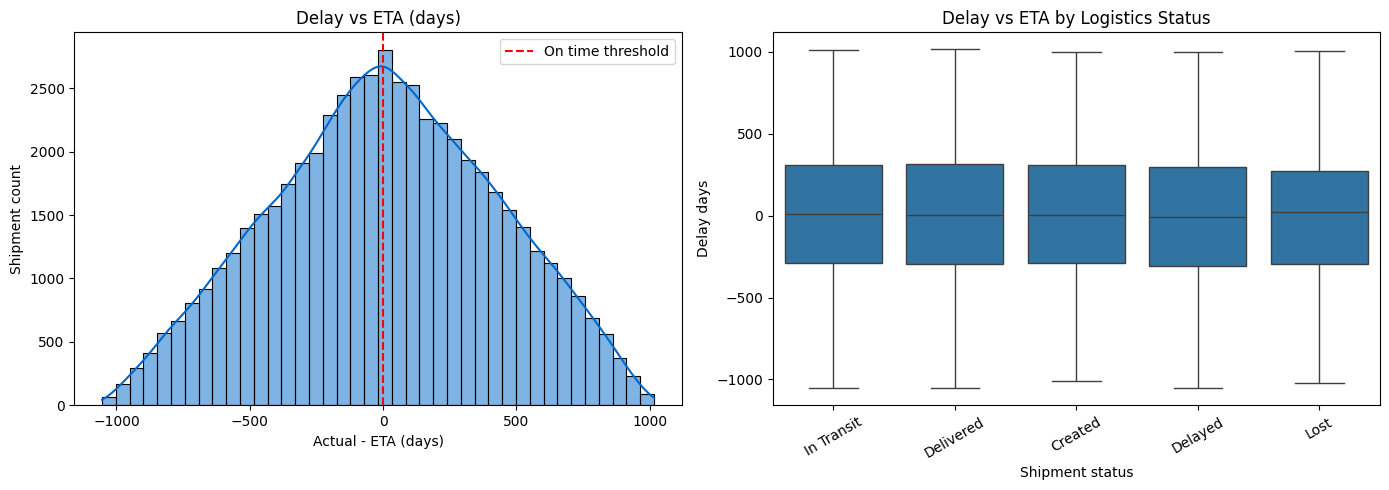

Delay summary by shipment.status (delivered only):


,status,delivered_samples,avg_delay_days,median_delay_days
0,In Transit,24780,7.910654,9.0
1,Delivered,20988,7.251096,6.0
2,Created,5474,6.447936,4.5
3,Delayed,3443,-7.300029,-10.0
4,Lost,547,1.524680,21.0


In [ ]:
# Visualize delay distributions for shipments that have delivered events
plot_ready = shipments_enriched.filter(pl.col("delay_vs_eta_days").is_not_null())
plot_df = plot_ready.select([
    "delay_vs_eta_days",
    "delay_vs_promised_days",
    "status"
]).to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(plot_df["delay_vs_eta_days"], bins=40, kde=True, ax=axes[0], color="#0068c9")
axes[0].axvline(0, color="red", linestyle="--", label="On time threshold")
axes[0].set_title("Delay vs ETA (days)")
axes[0].set_xlabel("Actual - ETA (days)")
axes[0].set_ylabel("Shipment count")
axes[0].legend()

sns.boxplot(data=plot_df, x="status", y="delay_vs_eta_days", ax=axes[1])
axes[1].set_title("Delay vs ETA by Logistics Status")
axes[1].set_xlabel("Shipment status")
axes[1].set_ylabel("Delay days")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

summary_df = (
    plot_ready
    .group_by("status")
    .agg([
        pl.len().alias("delivered_samples"),
        pl.col("delay_vs_eta_days").mean().alias("avg_delay_days"),
        pl.col("delay_vs_eta_days").median().alias("median_delay_days")
    ])
    .sort("delivered_samples", descending=True)
)
print("Delay summary by shipment.status (delivered only):")
display(summary_df.to_pandas().head(10))

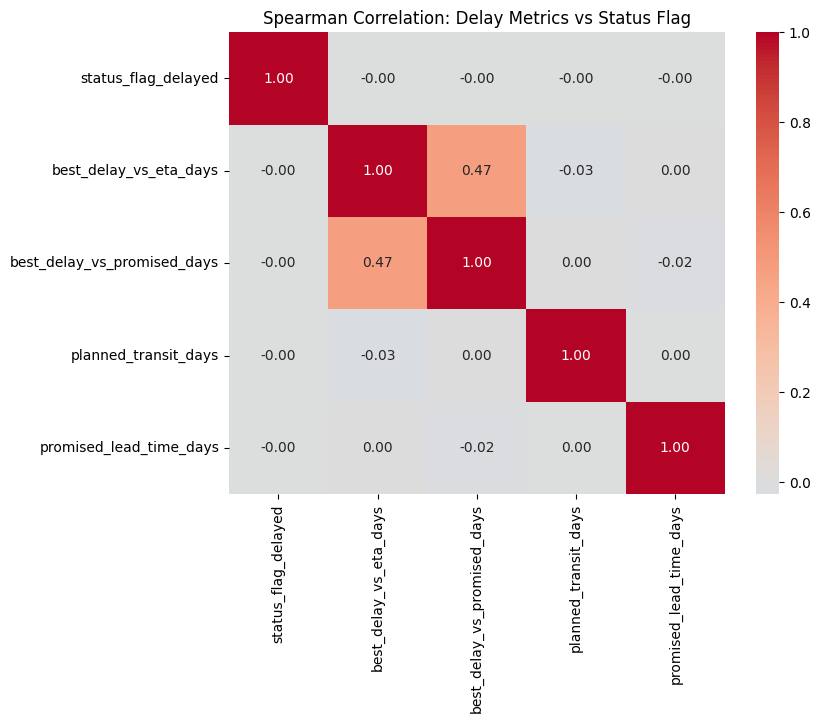

Correlation of status flag with each delay signal:


,best_delay_vs_eta_days,best_delay_vs_promised_days
status_flag_delayed,-0.002676,-0.001531


In [ ]:
# Correlation between shipment.status flag and computed delays
corr_input = (
    shipments_enriched
    .select([
        pl.when(pl.col("status") == "Delayed").then(1).otherwise(0).alias("status_flag_delayed"),
        pl.col("best_delay_vs_eta_days"),
        pl.col("best_delay_vs_promised_days"),
        pl.col("planned_transit_days"),
        pl.col("promised_lead_time_days"),
    ])
    .drop_nulls()
)

corr_df = corr_input.to_pandas()
corr_matrix = corr_df.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Spearman Correlation: Delay Metrics vs Status Flag")
plt.show()

print("Correlation of status flag with each delay signal:")
display(corr_matrix.loc[["status_flag_delayed"], ["best_delay_vs_eta_days", "best_delay_vs_promised_days"]])

In [ ]:
# Identify sample shipments for deeper inspection
samples = {
    "delayed_flag_no_delivery": (
        shipments_enriched
        .filter((pl.col("status") == "Delayed") & pl.col("actual_delivery_ts").is_null())
        .select("shipment_id")
        .head(2)
        .to_series()
        .to_list()
    ),
    "delayed_flag_arrived_early": (
        shipments_enriched
        .filter((pl.col("status") == "Delayed") & (pl.col("best_delay_vs_eta_days") < 0))
        .select("shipment_id")
        .head(2)
        .to_series()
        .to_list()
    ),
    "on_time_flag_but_late": (
        shipments_enriched
        .filter((pl.col("status") != "Delayed") & (pl.col("best_delay_vs_eta_days") > 20))
        .select("shipment_id")
        .head(2)
        .to_series()
        .to_list()
    ),
}

samples

{'delayed_flag_no_delivery': ['SH-00000002', 'SH-00000020'],
 'delayed_flag_arrived_early': ['SH-00000002', 'SH-00000288'],
 'on_time_flag_but_late': ['SH-00000003', 'SH-00000004']}

In [ ]:
# Inspect selected shipments using the helper
unique_samples = list({sid for cat in samples.values() for sid in cat})
for sid in unique_samples:
    print("=" * 40)
    print(f"Shipment: {sid}")
    explain_shipment_delay(sid)

Shipment: SH-00000003


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000003,PO-0110843,S-0178,2023-01-21,2023-01-30,In Transit,NaT,9,NaN,NaN,16,NaN,NaN,True,Latest status: In Transit (28 days vs ETA)


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000003,2023-02-27 07:00:00,Destination,In Transit


Shipment: SH-00000002


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000002,PO-0099598,S-0002,2024-08-21,2024-09-27,Delayed,NaT,37,NaN,NaN,18,NaN,NaN,False,Latest status: Out for Delivery (-201 days vs ...


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000002,2024-03-09 04:00:00,Final DC,Out for Delivery


Shipment: SH-00000004


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000004,PO-0047627,S-0091,2023-07-03,2023-08-05,In Transit,2025-09-02 20:00:00,33,792,759,35,310,275,True,Arrived 759 days after ETA


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000004,2024-05-22 15:00:00,Destination,Arrived Hub
1,SH-00000004,2024-06-03 01:00:00,Rail Yard,Released
2,SH-00000004,2024-08-26 12:00:00,Origin DC,Arrived Hub
3,SH-00000004,2025-09-02 20:00:00,Rail Yard,Delivered


Shipment: SH-00000020


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000020,PO-0097987,S-0200,2023-04-21,2023-05-29,Delayed,NaT,38,NaN,NaN,42,NaN,NaN,None,No transit events ingested


No transit events captured for this shipment.
Shipment: SH-00000288


,shipment_id,po_id,supplier_id,ship_date,eta_date,status,actual_delivery_ts,planned_transit_days,actual_transit_days,delay_vs_eta_days,promised_lead_time_days,actual_lead_time_days,delay_vs_promised_days,is_delayed_computed,delay_narrative
0,SH-00000288,PO-0002958,S-0025,2024-12-18,2025-01-21,Delayed,NaT,34,NaN,NaN,37,NaN,NaN,False,Latest status: Picked (-93 days vs ETA)


Transit timeline (sorted):


,shipment_id,event_ts,location_type,event_status
0,SH-00000288,2023-05-15 23:00:00,On Vehicle,Created
1,SH-00000288,2024-10-19 03:00:00,Airport,Picked


In [ ]:
# Compare status flag vs computed delay classification
comparison = (
    shipments_enriched
    .select([
        pl.col("status").alias("status_flag"),
        pl.when(pl.col("status") == "Delayed").then(1).otherwise(0).alias("status_flag_delayed"),
        pl.col("best_delay_vs_eta_days").alias("delay_days"),
    ])
    .drop_nulls()
    .with_columns([
        (pl.col("delay_days") > 0).alias("computed_delayed"),
    ])
)

confusion = (
    comparison
    .group_by("status_flag", "computed_delayed")
    .len()
    .pivot(
        values="len",
        index="status_flag",
        columns="computed_delayed"
    )
    .fill_null(0)
    .rename({"false": "On-time (<=0)", "true": "Late (>0)"})
)

print("Confusion matrix between status flag and computed delay > 0:")
display(confusion.to_pandas())

mislabel_rate = (
    comparison
    .with_columns((pl.col("status_flag_delayed") == pl.col("computed_delayed")).alias("matches"))
    .select([
        pl.len().alias("sample_size"),
        pl.col("matches").sum().alias("matching"),
        (1 - pl.col("matches").mean()).alias("mislabel_rate")
    ])
)
print("Overall agreement between status flag and computed delay:")
display(mislabel_rate.to_pandas())

Confusion matrix between status flag and computed delay > 0:


C:\Users\skibi\AppData\Local\Temp\ipykernel_11352\698343391.py:19: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


,status_flag,Late (>0),On-time (<=0)
0,Lost,1084,743
1,Delayed,6359,4770
2,In Transit,47365,34830
3,Created,10453,7753
4,Delivered,40145,29457


Overall agreement between status flag and computed delay:


,sample_size,matching,mislabel_rate
0,182959,79142,0.567433


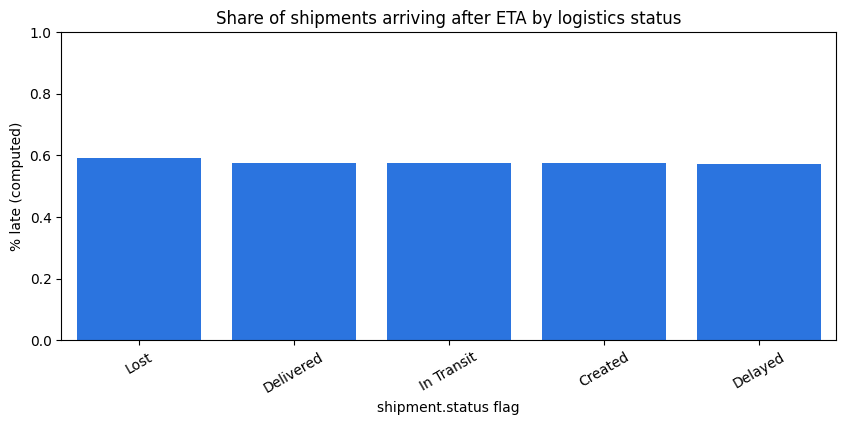

Delay stats by logistics status (sorted by share late):


,status,samples,share_late,avg_delay,median_delay
0,Lost,1827,0.593322,84.999453,89.0
1,Delivered,69602,0.576779,80.114278,85.0
2,In Transit,82195,0.576252,79.485759,81.0
3,Created,18206,0.574151,82.136329,81.0
4,Delayed,11129,0.571390,74.856231,77.0


In [ ]:
# Share of shipments with positive computed delay by logistics status
status_delay_share = (
    shipments_enriched
    .select([
        "status",
        pl.col("best_delay_vs_eta_days").alias("delay_days"),
    ])
    .drop_nulls()
    .group_by("status")
    .agg([
        pl.len().alias("samples"),
        (pl.col("delay_days") > 0).mean().alias("share_late"),
        pl.col("delay_days").mean().alias("avg_delay"),
        pl.col("delay_days").median().alias("median_delay"),
    ])
    .sort("share_late", descending=True)
)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=status_delay_share.to_pandas(),
    x="status",
    y="share_late",
    hue=None,
    color="#0d6efd"
)
plt.title("Share of shipments arriving after ETA by logistics status")
plt.ylabel("% late (computed)")
plt.xlabel("shipment.status flag")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

print("Delay stats by logistics status (sorted by share late):")
display(status_delay_share.to_pandas())